In [1]:
%config IPCompleter.greedy=True


### Loading packages and libraries 

In [2]:
import itertools
import numpy as np
from Bio import Align
from Bio import SeqIO
from Bio import pairwise2
from Bio.SubsMat.MatrixInfo import blosum62
import csv
import pandas as pd
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
import random
from random import randint
from sklearn.model_selection  import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import features_extraction_utility.kmer as kmer
from sklearn.svm import SVC
from xgboost import XGBClassifier
# import the metrics class
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc, classification_report
from sklearn import metrics
# import required modules for plotig
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
seed =45

# Reading np inter v 2 interactions

In [3]:
df_NPInter2 = pd.read_csv('../data/NPInter_v2.0 homo_sapiens_type_lncrna.csv')
df_NPInter2.shape


(5353, 16)

In [4]:
df_NPInter2.prIdentifier=df_NPInter2.prIdentifier.str.strip()

In [22]:
df_NPInter2.prIdentifier.unique()

array(['Q07955', 'Q01844', 'Q9UL18', 'Q9UKV8', 'Q9H9G7', 'Q9HCK5',
       'Q15717', 'B7ZL34', 'Q9NZI8', 'P26599', 'O00425', 'P35637',
       'P31483', 'Q9HCE1', 'Q86X94', 'Q49AS9', 'Q13148', 'Q9Y6M1',
       'Q96PU8', 'O43251', 'Q8NDV7', 'Q9UPQ9', 'Q9HCJ0', 'Q13285',
       'Q6PJX3'], dtype=object)

In [23]:
pro_PseAAC.keys()

dict_keys(['Q07955', 'Q01844', 'Q9UL18', 'Q9UKV8', 'Q9H9G7', 'Q9HCK5', 'Q15717', 'B7ZL34', 'Q9NZI82', 'P26599', 'O00425', 'P35637', 'P31483', 'Q9HCE1', 'Q86X94', 'Q49AS9', 'Q13148', 'Q9Y6M1', 'Q96PU8', 'O43251', 'Q8NDV7', 'Q9UPQ9', 'Q9HCJ0', 'Q13285', 'Q6PJX3'])

## physical-chemical features 

In [16]:
#lncrna features

lnc_dac1 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_0-300.txt", "fasta"))
lnc_dac2 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_301-600.txt", "fasta"))
lnc_dac3 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_601-900.txt", "fasta"))
lnc_dac4 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_901-1200.txt", "fasta"))

lnc_dac5 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_1201-1500.txt", "fasta"))
lnc_dac6 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_1501-1800.txt", "fasta"))
lnc_dac7 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_1801-1923.txt", "fasta"))

lnc_DAC ={**lnc_dac1 , **lnc_dac2 , **lnc_dac3 , **lnc_dac4 , **lnc_dac5 , **lnc_dac6 , **lnc_dac7}

In [18]:
print(len(lnc_DAC))
#print(lnc_DAC.keys())

1923


In [55]:
#protein features.
pro_PseAAC = SeqIO.to_dict(SeqIO.parse("../Data/Protein  PC-PseAAC-General/PC-PseAAC-General.txt", "fasta"))
print(len(pro_PseAAC))
print(str(pro_PseAAC['Q07955'].seq))

25
0.018,0.004,0.036,0.02,0.013,0.063,0.005,0.013,0.014,0.011,0.005,0.013,0.03,0.002,0.077,0.05,0.013,0.03,0.002,0.027,0.062,0.048,0.056,0.054,0.056,0.058,0.056,0.056,0.056,0.054


In [53]:
str(lnc_dac1['n344453'].seq)

'0.001,-0.665,0.03,-0.544,-0.0,0.008,0.0,-0.011,0.01,-0.063,-0.0,0.001,0.0,0.034,0.008,-0.001,0.0,0.003,0.0,-0.185,0.014,-0.032,0.0,0.003,0.001,0.203,0.005,0.06,0.0,0.003,0.0,0.049,0.0,0.046,0.0,0.002,0.0,0.165,-0.001,0.024,0.0,0.003,0.0,0.001,0.003,-0.01,0.0,0.002,0.0,-0.042,-0.001,-0.03,0.0,0.001,0.0,-0.076,-0.004,-0.022,0.0,0.002'

In [50]:
type(pro_PseAAC['Q07955'].seq)

Bio.Seq.Seq

### preparing the features set for NPInterV2 dataset

In [56]:
# creating features from npinter v2

def prepare_NPinter_feature_DAC(pro_PseAAC, lnc_DAC, df_NPInter2):
    # create dict of proteins
    pro_dict=pro_PseAAC
    # create dict of lncRnas
    lnc_dict = lnc_DAC
    # positive set
    posi_set = set()
    pro_set = set()
    X_features =[]
    Y_labels =[]
    df_interact = pd.DataFrame(columns=['ncIdentifier', 'prIdentifier', 'interaction'])
    # geting positive class
    for index, row in tqdm(df_NPInter2.iterrows()):
        ncIdentifier=row['ncIdentifier'].strip()
        prIdentifier =row['prIdentifier'].strip()
        posi_set.add((ncIdentifier, prIdentifier))
        pro_set.add(prIdentifier)
        if (ncIdentifier in lnc_dict) and (prIdentifier in pro_dict):
            PseAAC=str(pro_dict[prIdentifier].seq)
            DAC = str(lnc_dict[ncIdentifier].seq)
            df_interact = df_interact.append({'ncIdentifier': ncIdentifier, 'prIdentifier': prIdentifier, 'interaction': 1}, ignore_index=True)
            pro_fea = PseAAC.split(",")
            lnc_fea = DAC.split(",")
            #X_features.append((sim_lst_pro,sim_lst_lnc))
            X_features.append(pro_fea + lnc_fea)
            Y_labels.append(1)

        else:
            print(prIdentifier)
    #getting negative data or class
    pro_list = list(pro_set)   
    total_pro_len = len(pro_list)  
    for index, row in tqdm(df_NPInter2.iterrows()):
        ncIdentifier=row['ncIdentifier'].strip()
        prIdentifier =row['prIdentifier'].strip()
        #posi_set.add((ncIdentifier, prIdentifier))
        for val in range(50):
                    random_choice = randint(0,total_pro_len-1)
                    select_pro = pro_list[random_choice]
                    selec_nega= (ncIdentifier, select_pro)
                    if selec_nega not in posi_set:
                        posi_set.add(selec_nega)
                        #print selec_nega
                        break
        if (ncIdentifier in lnc_dict) and (select_pro in pro_dict):
            PseAAC=str(pro_dict[prIdentifier].seq)
            DAC = str(lnc_dict[ncIdentifier].seq)
            df_interact = df_interact.append({'ncIdentifier': ncIdentifier, 'prIdentifier': prIdentifier, 'interaction': 1}, ignore_index=True)
            pro_fea = PseAAC.split(",")
            lnc_fea = DAC.split(",")
            #X_features.append((sim_lst_pro,sim_lst_lnc))
            X_features.append(pro_fea + lnc_fea)
            Y_labels.append(0)
    return df_interact,np.array(X_features) , Y_labels

        
    


In [57]:
df_interact_DAC, X_Features_DAC, Y_Labels_DAC=prepare_NPinter_feature_DAC(pro_PseAAC, lnc_DAC, df_NPInter2)
df_interact_DAC.shape


0it [00:00, ?it/s]
27it [00:00, 267.48it/s]
55it [00:00, 268.82it/s]
86it [00:00, 279.26it/s]
117it [00:00, 286.28it/s]
149it [00:00, 294.04it/s]
180it [00:00, 297.84it/s]
207it [00:00, 286.20it/s]
239it [00:00, 293.99it/s]
268it [00:00, 289.32it/s]
299it [00:01, 292.77it/s]
328it [00:01, 291.11it/s]
358it [00:01, 292.05it/s]
387it [00:01, 281.31it/s]
418it [00:01, 288.58it/s]
449it [00:01, 293.90it/s]
479it [00:01, 290.60it/s]
509it [00:01, 285.86it/s]
538it [00:01, 281.29it/s]
568it [00:01, 284.26it/s]
597it [00:02, 282.66it/s]
626it [00:02, 283.20it/s]
655it [00:02, 281.93it/s]
684it [00:02, 278.62it/s]
712it [00:02, 278.25it/s]
742it [00:02, 282.07it/s]
772it [00:02, 285.63it/s]
802it [00:02, 288.17it/s]
831it [00:02, 287.91it/s]
861it [00:02, 290.63it/s]
891it [00:03, 289.19it/s]
922it [00:03, 293.51it/s]
953it [00:03, 296.60it/s]
983it [00:03, 293.30it/s]
1013it [00:03, 291.03it/s]
1043it [00:03, 292.86it/s]
1073it [00:03, 289.05it/s]
1102it [00:03, 285.12it/s]
1131it [00:03, 28

2998it [00:12, 187.41it/s]
3017it [00:12, 187.10it/s]
3036it [00:12, 185.79it/s]
3055it [00:12, 183.81it/s]
3075it [00:12, 187.88it/s]
3096it [00:12, 193.51it/s]
3116it [00:12, 188.27it/s]
3135it [00:13, 183.36it/s]
3154it [00:13, 182.66it/s]
3176it [00:13, 191.98it/s]
3197it [00:13, 195.44it/s]
3218it [00:13, 197.37it/s]
3238it [00:13, 191.36it/s]
3259it [00:13, 196.08it/s]
3279it [00:13, 194.97it/s]
3299it [00:13, 190.32it/s]
3319it [00:14, 182.58it/s]
3338it [00:14, 178.53it/s]
3356it [00:14, 174.32it/s]
3374it [00:14, 171.98it/s]
3392it [00:14, 173.84it/s]
3413it [00:14, 181.43it/s]
3432it [00:14, 183.42it/s]
3452it [00:14, 186.55it/s]
3471it [00:14, 185.41it/s]
3490it [00:14, 182.49it/s]
3509it [00:15, 179.99it/s]
3528it [00:15, 176.29it/s]
3546it [00:15, 176.38it/s]
3564it [00:15, 173.88it/s]
3582it [00:15, 172.67it/s]
3610it [00:15, 193.91it/s]
3638it [00:15, 213.16it/s]
3664it [00:15, 223.63it/s]
3688it [00:15, 227.04it/s]
3713it [00:16, 231.57it/s]
3737it [00:16, 233.39it/s]
3

(10706, 3)

In [166]:
print(X_Features_DAC[0])

[ 0.018  0.004  0.036  0.02   0.013  0.063  0.005  0.013  0.014  0.011
  0.005  0.013  0.03   0.002  0.077  0.05   0.013  0.03   0.002  0.027
  0.062  0.048  0.056  0.054  0.056  0.058  0.056  0.056  0.056  0.054
  0.001 -0.994  0.067 -0.282 -0.     0.005 -0.001  0.129 -0.005 -0.053
  0.     0.001 -0.     0.019  0.001 -0.007 -0.     0.     0.    -0.09
  0.026  0.025  0.     0.     0.     0.019  0.017  0.021  0.     0.001
  0.     0.095  0.034  0.014  0.     0.001 -0.    -0.035  0.003 -0.008
  0.     0.001  0.    -0.133  0.01   0.023  0.     0.    -0.     0.241
  0.007  0.005  0.     0.001  0.     0.011  0.006  0.029 -0.     0.001]


In [61]:
import csv



with open("X_Features_DAC.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(map(lambda x: [x], X_Features_DAC))    
    
print("done...")    

done...


In [32]:
#df_lnc_sim.count()

In [30]:
# save pairs to disk
df_interact_DAC.to_csv('../data/NpInterV2_Pairs_full_DAC.csv')

### Model



#### train test split

In [141]:
#spliting train test
X_Features_DAC=X_Features_DAC.astype(float)
X_train,X_test,y_train,y_test=train_test_split(X_Features_DAC,Y_Labels_DAC,test_size=0.25,random_state=0)
len(X_train)

8029

## PCA

In [105]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.80)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [106]:
len(X_train[0])

42

### building model

In [113]:
def train_model(model,X_train,y_train):
        
    # fiting kfold model
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
    pred_test_full =0
    cv_score =[]
    i=1
    y_train1=np.array(y_train)
    #y_train1=y_train1.reshape(-1,1)
    #print(y_train.shape)
    #print(X_train.shape)

    for train_index,test_index in kf.split(X_train,y_train1):
        print('{} of KFold {}'.format(i,kf.n_splits))
        #print(train_index)
        #print(test_index)
        xtr,xvl = X_train[train_index],X_train[test_index]
        ytr,yvl = y_train1[train_index],y_train1[test_index]
        #print(xtr[0])
        #print(ytr[0])

        #model
        #medel = LogisticRegression(solver='lbfgs')#LogisticRegression(C=2)
        model.fit(xtr,ytr)
        score = roc_auc_score(yvl,model.predict(xvl))
        print('ROC AUC score:',score)
        cv_score.append(score)    
        pred_test = model.predict_proba(X_test)[:,1]
        pred_test_full +=pred_test
        i+=1
    return model,xtr,xvl, ytr,yvl,cv_score    

### Logistic Regration Model


In [142]:
model = LogisticRegression(solver='lbfgs')#LogisticRegression(C=2)
model,xtr,xvl, ytr,yvl,cv_score =train_model(model,X_train,y_train)

1 of KFold 5
ROC AUC score: 0.46056192758377346
2 of KFold 5
ROC AUC score: 0.48281025831918045
3 of KFold 5
ROC AUC score: 0.47184545828195645
4 of KFold 5
ROC AUC score: 0.4795624626790437
5 of KFold 5
ROC AUC score: 0.47907860122310675


In [143]:
print('Confusion matrix on validation set: \n',confusion_matrix(yvl,model.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))


Confusion matrix on validation set: 
 [[330 464]
 [371 440]]
Cv [0.46056192758377346, 0.48281025831918045, 0.47184545828195645, 0.4795624626790437, 0.47907860122310675] 
Mean cv Score 0.47477174161741215


In [144]:
print("Results on validation set: ")
print("Accuracy:",metrics.accuracy_score(yvl, model.predict(xvl)))
print("Precision:",metrics.precision_score(yvl, model.predict(xvl)))
print("Recall:",metrics.recall_score(yvl, model.predict(xvl)))
print("F1 Score:",metrics.f1_score(yvl, model.predict(xvl)))

Results on validation set: 
Accuracy: 0.4797507788161994
Precision: 0.48672566371681414
Recall: 0.5425400739827374
F1 Score: 0.5131195335276968


In [145]:
print("Results on test set:")
y_pred=model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Results on test set:


array([[559, 820],
       [573, 725]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

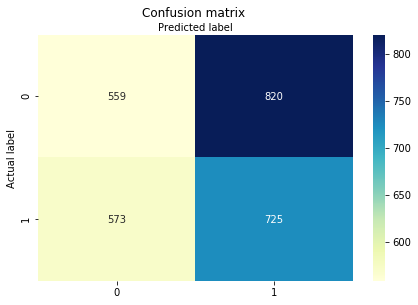

In [146]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [148]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.47964138961524094
Precision: 0.4692556634304207
Recall: 0.5585516178736518
F1 Score: 0.5100246218782976


In [120]:
#lr.coef_


In [149]:
print("validation set score:")
print(model.score(xvl,yvl))

print("test set score:")
print(model.score(X_test,y_test))


validation set score:
0.4797507788161994
test set score:
0.47964138961524094


### Reciever Operating Characteristics


Text(0.5, 0, 'False positive rate')

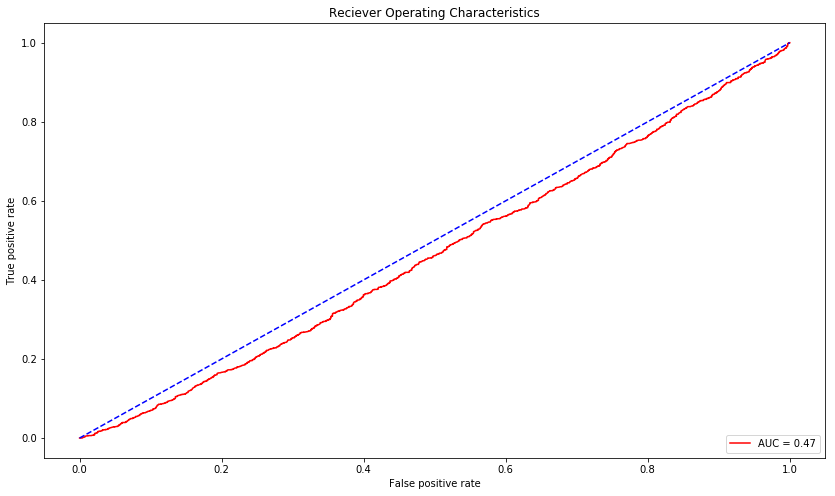

In [150]:
# proba = model.predict_proba(xvl)[:,1]
# frp,trp, threshold = roc_curve(yvl,proba)
proba = model.predict_proba(X_test)[:,1]
frp,trp, threshold = roc_curve(y_test,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### XGBoost Model


In [151]:
model = XGBClassifier(learning_rate=0.05, n_estimators=50, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

model,xtr,xvl, ytr,yvl,cv_score =train_model(model,X_train,y_train)

1 of KFold 5
ROC AUC score: 0.3493892934415932
2 of KFold 5
ROC AUC score: 0.34261607302111685
3 of KFold 5
ROC AUC score: 0.3761107104359088
4 of KFold 5
ROC AUC score: 0.3677608977192534
5 of KFold 5
ROC AUC score: 0.3659078414868605


In [152]:
print('Confusion matrix on validation set: \n',confusion_matrix(yvl,model.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))


Confusion matrix on validation set: 
 [[257 537]
 [480 331]]
Cv [0.3493892934415932, 0.34261607302111685, 0.3761107104359088, 0.3677608977192534, 0.3659078414868605] 
Mean cv Score 0.36035696322094657


In [153]:
print("Results on validation set: ")
print("Accuracy:",metrics.accuracy_score(yvl, model.predict(xvl)))
print("Precision:",metrics.precision_score(yvl, model.predict(xvl)))
print("Recall:",metrics.recall_score(yvl, model.predict(xvl)))
print("F1 Score:",metrics.f1_score(yvl, model.predict(xvl)))

Results on validation set: 
Accuracy: 0.3663551401869159
Precision: 0.3813364055299539
Recall: 0.4081381011097411
F1 Score: 0.39428231089934485


In [154]:
print("Results on test set:")
y_pred=model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Results on test set:


array([[464, 915],
       [782, 516]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

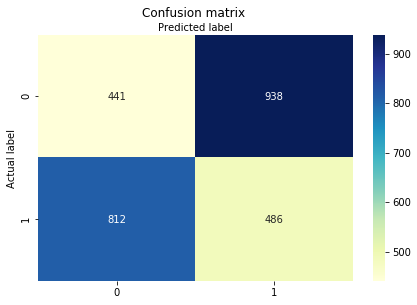

In [127]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [155]:
print("Results on test set: ")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Results on test set: 
Accuracy: 0.366081434441539
Precision: 0.36058700209643607
Recall: 0.3975346687211094
F1 Score: 0.3781604983510443


In [129]:
#lr.coef_


In [156]:
print("validation set score:")
print(model.score(xvl,yvl))

print("test set score:")
print(model.score(X_test,y_test))


validation set score:
0.3663551401869159
test set score:
0.366081434441539


### Reciever Operating Characteristics


Text(0.5, 0, 'False positive rate')

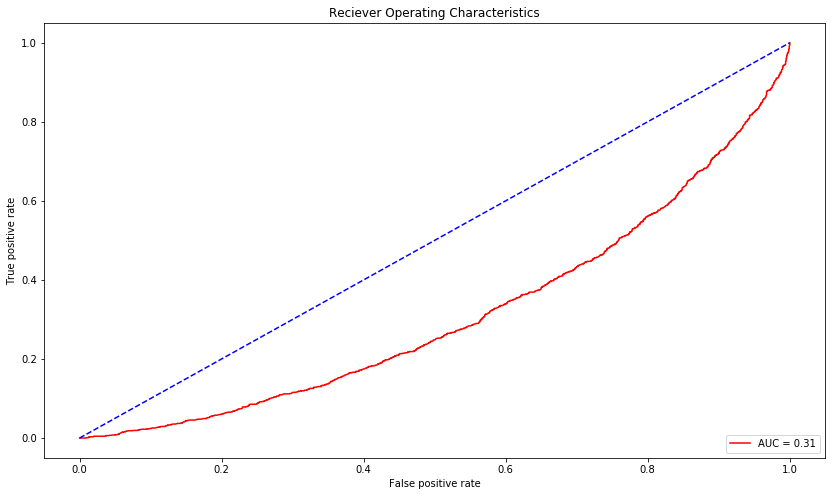

In [157]:
#proba = model.predict_proba(xvl)[:,1]
#frp,trp, threshold = roc_curve(yvl,proba)
proba = model.predict_proba(X_test)[:,1]
frp,trp, threshold = roc_curve(y_test,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### SVM

In [158]:
model = SVC(kernel='linear',probability=True)

model,xtr,xvl, ytr,yvl,cv_score =train_model(model,X_train,y_train)

1 of KFold 5
ROC AUC score: 0.5
2 of KFold 5
ROC AUC score: 0.4970042419871422
3 of KFold 5
ROC AUC score: 0.49351604122560083
4 of KFold 5
ROC AUC score: 0.5
5 of KFold 5
ROC AUC score: 0.499383477188656


In [159]:
print('Confusion matrix on validation set: \n',confusion_matrix(yvl,model.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))


Confusion matrix on validation set: 
 [[  0 794]
 [  1 810]]
Cv [0.5, 0.4970042419871422, 0.49351604122560083, 0.5, 0.499383477188656] 
Mean cv Score 0.4979807520802798


In [160]:
print("Results on validation set: ")
print("Accuracy:",metrics.accuracy_score(yvl, model.predict(xvl)))
print("Precision:",metrics.precision_score(yvl, model.predict(xvl)))
print("Recall:",metrics.recall_score(yvl, model.predict(xvl)))
print("F1 Score:",metrics.f1_score(yvl, model.predict(xvl)))

Results on validation set: 
Accuracy: 0.5046728971962616
Precision: 0.5049875311720698
Recall: 0.998766954377312
F1 Score: 0.6708074534161491


In [161]:
print("Results on test set:")
y_pred=model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Results on test set:


array([[   0, 1379],
       [   0, 1298]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

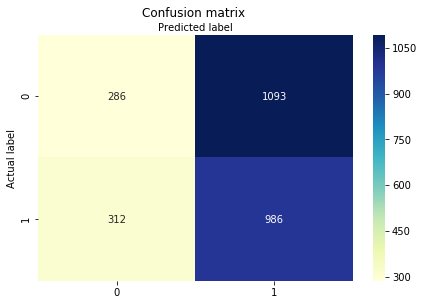

In [136]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [162]:
print('results on test set')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

results on test set
Accuracy: 0.4848711243929772
Precision: 0.4848711243929772
Recall: 1.0
F1 Score: 0.6530817610062892


In [138]:
#lr.coef_


In [163]:
print("validation set score:")
print(model.score(xvl,yvl))

print("test set score:")
print(model.score(X_test,y_test))


validation set score:
0.5046728971962616
test set score:
0.4848711243929772


### Reciever Operating Characteristics


Text(0.5, 0, 'False positive rate')

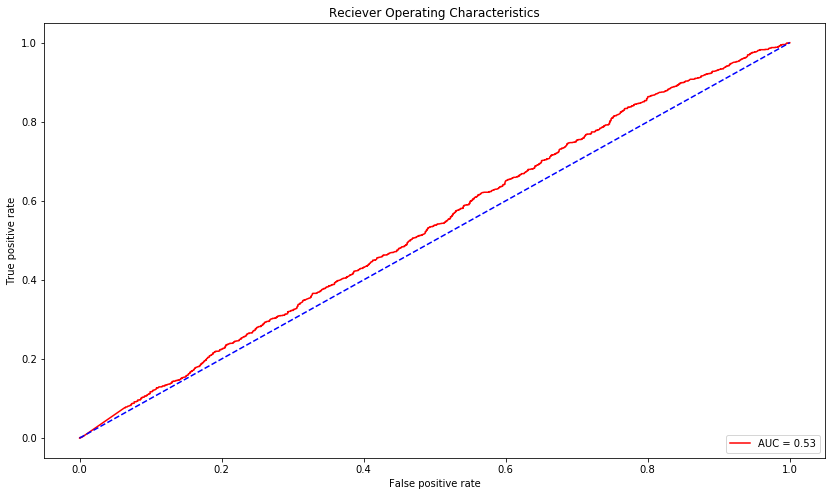

In [164]:
#proba = model.predict_proba(xvl)[:,1]
#frp,trp, threshold = roc_curve(yvl,proba)
proba = model.predict_proba(X_test)[:,1]
frp,trp, threshold = roc_curve(y_test,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')